In [1]:
%matplotlib inline
import quantstats as qs
import os
import glob
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
def addZero(num):
    if len(str(num)) == 1:
        return '0{0}'.format(num)
    else:
        return str(num)
    
listMonths = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# получает данные по инструменту на определенную дату (если на указанную дату нет файлика, то берет данные на след.день)
def getData(instrument, dd1):
    foundFile = False
    fileName = r'E:\Date\OptionHistory\{0}\L3_options_{0}{2}{3}.csv'.format(dd1.year, listMonths[dd1.month-1], addZero(dd1.month), addZero(dd1.day))
    if os.path.exists(fileName):
        foundFile = True
    
    if foundFile:
        tabIn = pd.read_csv(fileName, sep=',', header=0)
        #print (dt.datetime.now())
        tabII = tabIn[(tabIn['UnderlyingSymbol']==instrument)]
        tabII['Expiration'] = pd.to_datetime(tabII['Expiration'])
        return tabII 
    else:
        return pd.DataFrame()

# получает данные по инструменту на определенную дату (если на указанную дату нет файлика, то берет данные на след.день)
def getDataUp(instrument, dd1, UpDown):
    foundFile = False
    fileName = r'OptionHistory\L3_{0}_{1}\L3_options_{0}{2}{3}.csv'.format(dd1.year, listMonths[dd1.month-1], addZero(dd1.month), addZero(dd1.day))
    if os.path.exists(fileName):
        foundFile = True
    else:
        if UpDown == 'up':
            for ii in range(1,11):
                dd2 = dd1 + dt.timedelta(days=ii)
                fileName = r'OptionHistory\L3_{0}_{1}\L3_options_{0}{2}{3}.csv'.format(dd2.year, listMonths[dd2.month-1], addZero(dd2.month), addZero(dd2.day))
                if os.path.exists(fileName):
                    foundFile = True
                    break
        else:
            for ii in range(1,11):
                dd2 = dd1 - dt.timedelta(days=ii)
                fileName = r'OptionHistory\L3_{0}_{1}\L3_options_{0}{2}{3}.csv'.format(dd2.year, listMonths[dd2.month-1], addZero(dd2.month), addZero(dd2.day))
                if os.path.exists(fileName):
                    foundFile = True
                    break
    if foundFile:
        tabIn = pd.read_csv(fileName, sep=',', header=0)
        #print (dt.datetime.now())
        tabII = tabIn[(tabIn['UnderlyingSymbol']==instrument)]
        tabII['Expiration'] = pd.to_datetime(tabII['Expiration'])
        return tabII 
    else:
        return pd.DataFrame()
    
def getOptionType(di):
    if di == 1:
        return 'call'
    elif di == -1:
        return 'put'
    
def getExpiration(dd1, expirs):
    dateNew = dd1 + dt.timedelta(days=30)
    expi = pd.to_datetime(expirs.unique()).sort_values()
    for el in expi:
        if el >= dateNew:
            return el
            break
    return 0

def getExpiration111(dd1, expirs):
    dateNew = dd1 + dt.timedelta(days=90)
    expi = pd.to_datetime(expirs.unique()).sort_values()
    for el in expi:
        if el >= dateNew:
            return el
            break
    return 0

def getStrDate(date):
    return str((date).strftime(format='%d.%m.%Y'))

def getATM12(ulPrice, strikes):
    returnStrike = 0.0
    stri = pd.to_numeric(strikes.unique())
    stri.sort()
    for e in np.arange(1, len(stri)):
        if ulPrice >= stri[e-1] and ulPrice <= stri[e]:
            if (ulPrice-stri[e-1]) == (stri[e]-ulPrice):
                returnStrike = stri[e-1]
                break
            elif (ulPrice-stri[e-1]) > (stri[e]-ulPrice):
                returnStrike = stri[e]
                break
            else:
                returnStrike = stri[e-1]
                break
    return returnStrike

def getATM111(ulPrice, strikes, dirr):
    stri = pd.to_numeric(strikes.unique())
    stri.sort()
    ij = 0
    for e in np.arange(1, len(stri)):
        if ulPrice >= stri[e-1] and ulPrice <= stri[e]:
            ij = e
            break
    if dirr == 1:
        if ij+1 < len(stri):
            return stri[ij+1]
    elif dirr == -1:
        if ij-1 >= 0:
            return stri[ij-1]          
    return stri[ij]

def getPrice(Last, Ask, Bid):
    if Last == 0.0:
        return (Bid + Ask) / 2
    else:
        return Last
    
def strDate(date):
    return str(date.strftime(format='%d.%m.%Y'))


In [3]:
def getDelta(df, dirr, delta, date1):
    df = df[df['Type']==getOptionType(dirr)]
    dd = getNeededDelta(df, delta, date1)
    df1 = df[df['Delta']==dd]
    if len(df1) > 0:
        return df1
    else:
        return pd.DataFrame()
    
def getATM(df, dirr, date1):
    df = df[df['Type']==getOptionType(dirr)]
    df = df[date1 + dt.timedelta(days=30) <= df['Expiration']] 
    ulPrice = df['UnderlyingPrice'].iloc[0]
    strikes = pd.to_numeric(df['Strike'].unique())
    strikes.sort()
    listDiff = list(abs(ulPrice - strikes))
    ii = listDiff.index(min(listDiff))
    df1 = df[(df['Strike']==strikes[ii]) & (df['Expiration']==min(df['Expiration'].unique()))]
    if len(df1) > 0:
        return df1
    else:
        return pd.DataFrame()
    
def getOptionName(df, optionName):
    df1 = df[df['OptionSymbol'] == optionName]
    if len(df1) > 0:
        return df1
    else:
        return pd.DataFrame()
    
def getNeededDelta(df, val, date1):
    df = df[date1 + dt.timedelta(days=30) <= df['Expiration']]
    deltas = df['Delta'].unique()
    qqq = abs(deltas)
    qqq = list(abs(val-qqq))
    ii = qqq.index(min(qqq))
    return deltas[ii]

In [30]:
# begin new strategy
tabSignals = pd.read_csv(r'Signaly.csv', sep=';', header=0)#, parse_dates=['Date'])
tabSignals['Date'] = pd.to_datetime(tabSignals['Date'], format='%d.%m.%Y')
tabSignals.index = tabSignals['Date']
tabSignals['Date1'] = tabSignals['Date'].shift(-1)
tabSignals = tabSignals[['Date1', 'signal_hsi(china index)', 'signal_mid cap_US_ind', 'signal_bond(Treasures)']]
tabSignals = tabSignals[tabSignals.index.year >= 2004] #== 2006) & (tabSignals.index.month == 12)]

In [31]:
methodOption = 'Combination'
neededDelta = 0.25
takeProfit = 3
#
takeIsComing = ''
#
chinaIndex = 'FXI'
midCapUS = 'IWS'
bondTreasures = 'IEF'
tabSignals['Ticker'] = 'ticker'
tabSignals['Direction'] = 0.0
#
tabSignals['OptionName'] = ''
tabSignals['Price'] = 0.0
tabSignals['UnderlyingPrice'] = 0.0
tabSignals['Delta'] = 0.0
tabSignals['Expiration'] = ''
tabSignals['Details'] = ''
tabSignals['Strike'] = 0.0
tabSignals['Volume'] = 0.0
tabSignals['OpenInterest'] = 0.0
tabSignals['T1OpenInterest'] = 0.0
tabSignals['PL'] = 0.0
#
priceEnter = 0
ulPriceEnter = 0
indEnter = 0
# 
for ij in range(0,len(tabSignals)-1):
    print ('{0}::{1}'.format(ij, tabSignals['Date1'].iloc[ij]))
    #
    if tabSignals['signal_hsi(china index)'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = chinaIndex
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_hsi(china index)'].iloc[ij]
    elif tabSignals['signal_mid cap_US_ind'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = midCapUS
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_mid cap_US_ind'].iloc[ij]
    elif tabSignals['signal_bond(Treasures)'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = bondTreasures
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_bond(Treasures)'].iloc[ij]
        
    # 
    ddf = getData(tabSignals['Ticker'].iloc[ij], tabSignals['Date1'].iloc[ij])
    if len(ddf) > 0:
        ddf1 = pd.DataFrame()
        if ij != 0:
            if tabSignals['OptionName'].iloc[ij-1] != '':
                ddf1 = ddf[ddf['OptionSymbol'] == tabSignals['OptionName'].iloc[ij-1]]
    
        if len(ddf1) == 0 or tabSignals['Details'].iloc[ij-1].find('Exit') >= 0:
            if methodOption == 'ATM':
                ddf1 = getATM(ddf, tabSignals['Direction'].iloc[ij], tabSignals['Date1'].iloc[ij])
            elif methodOption == 'Combination':
                if tabSignals['Ticker'].iloc[ij] == 'FXI':
                    #ddf1 = getATM(ddf, tabSignals['Direction'].iloc[ij], tabSignals['Date1'].iloc[ij])
                    ddf1 = getDelta(ddf, tabSignals['Direction'].iloc[ij], 0.1, tabSignals['Date1'].iloc[ij])
                else:
                    ddf1 = getDelta(ddf, tabSignals['Direction'].iloc[ij], neededDelta, tabSignals['Date1'].iloc[ij])
            else:
                ddf1 = getDelta(ddf, tabSignals['Direction'].iloc[ij], neededDelta, tabSignals['Date1'].iloc[ij])
                
            #ddf1 = ddf[ddf['Type'] == getOptionType(tabSignals['Direction'].iloc[ij])]
            #dd = 0.1
            #delta = getNeededDelta(dd, ddf1['Delta'].unique())
            #ddf1 = ddf[ddf['Delta']==delta]
            if takeIsComing != '':
                if takeIsComing == tabSignals['Ticker'].iloc[ij]:
                    continue
            #
            if len(ddf1) == 0:
                continue
            
            takeIsComing = ''
            tabSignals['Details'].iloc[ij] = 'Enter'
            tabSignals['Price'].iloc[ij] = getPrice(ddf1['Last'].iloc[0], ddf1['Ask'].iloc[0], ddf1['Bid'].iloc[0])
            priceEnter = tabSignals['Price'].iloc[ij]
            ulPriceEnter = ddf1['UnderlyingPrice'].iloc[0]
            indEnter = ij
            
            if ij != 0:
                if tabSignals['Ticker'].iloc[ij] != tabSignals['Ticker'].iloc[ij-1]:
                    if tabSignals['Details'].iloc[ij-1] == 'Enter':
                        dr = getData(tabSignals['Ticker'].iloc[ij-1], tabSignals['Date1'].iloc[ij])
                        dm = getOptionName(dr, tabSignals['OptionName'].iloc[ij-1])
                        if len(dm) > 0:
                            priceP = getPrice(dm['Last'].iloc[0], dm['Ask'].iloc[0], dm['Bid'].iloc[0])
                            tabSignals['Details'].iloc[ij-1] = 'Enter;Exit_Signal;Price={0}'.format(priceP)
                            tabSignals['PL'].iloc[ij-1] = priceP - tabSignals['Price'].iloc[ij-1]  
                    else:
                        if tabSignals['Details'].iloc[ij-1] != '':
                            tabSignals['Details'].iloc[ij-1] = 'Exit_Signal'
        else:
            tabSignals['Details'].iloc[ij] = 'in'
            tabSignals['Price'].iloc[ij] = getPrice(ddf1['Last'].iloc[0], ddf1['Ask'].iloc[0], ddf1['Bid'].iloc[0])
        
        tabSignals['OptionName'].iloc[ij] = ddf1['OptionSymbol'].iloc[0]
        tabSignals['UnderlyingPrice'].iloc[ij] =  ddf1['UnderlyingPrice'].iloc[0]
        tabSignals['Delta'].iloc[ij] = ddf1['Delta'].iloc[0]
        tabSignals['Expiration'].iloc[ij] = ddf1['Expiration'].iloc[0] 
        tabSignals['Strike'].iloc[ij] = ddf1['Strike'].iloc[0]
        tabSignals['Volume'].iloc[ij] = ddf1['Volume'].iloc[0]
        tabSignals['OpenInterest'].iloc[ij] = ddf1['OpenInterest'].iloc[0]
        tabSignals['T1OpenInterest'].iloc[ij] = ddf1['T1OpenInterest'].iloc[0]
        
        if ij != 0:
            if tabSignals['OptionName'].iloc[ij-1] == tabSignals['OptionName'].iloc[ij]:
                if tabSignals['Price'].iloc[ij] != 0:
                    tabSignals['PL'].iloc[ij] = tabSignals['Price'].iloc[ij] - tabSignals['Price'].iloc[ij-1]
        
        if tabSignals['Details'].iloc[ij] == 'in':
            if tabSignals['Price'].iloc[ij] >= takeProfit * priceEnter:
                tabSignals['Details'].iloc[ij] = 'Exit_TakeP'
                takeIsComing = tabSignals['Ticker'].iloc[ij]
            if ij + 1 < len(tabSignals):
                if tabSignals['Date1'].iloc[ij] <= tabSignals['Expiration'].iloc[ij] and tabSignals['Expiration'].iloc[ij] <= tabSignals['Date1'].iloc[ij+1]:
                    #takeIsComing = tabSignals['Ticker'].iloc[ij] # если не нужно заходить после экспирации
                    tabSignals['Details'].iloc[ij] = 'Exit_Expir'
                    if tabSignals['Direction'].iloc[ij] == 1: 
                        tabSignals['PL'].iloc[ij] = max(tabSignals['UnderlyingPrice'].iloc[ij]-tabSignals['Strike'].iloc[ij],0)-priceEnter
                    elif tabSignals['Direction'].iloc[ij] == -1:
                        tabSignals['PL'].iloc[ij] = max(tabSignals['Strike'].iloc[ij]-tabSignals['UnderlyingPrice'].iloc[ij],0)-priceEnter
                    for el in range(indEnter, ij):
                        tabSignals['PL'].iloc[el] = 0.0
                          
tabSignals.to_csv(r'Delta025TP3_FXIatm.csv', sep=';')

0::2004-01-05 00:00:00


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1::2004-01-06 00:00:00
2::2004-01-07 00:00:00
3::2004-01-08 00:00:00
4::2004-01-09 00:00:00
5::2004-01-12 00:00:00
6::2004-01-13 00:00:00
7::2004-01-14 00:00:00
8::2004-01-15 00:00:00
9::2004-01-16 00:00:00
10::2004-01-20 00:00:00
11::2004-01-21 00:00:00
12::2004-01-22 00:00:00
13::2004-01-23 00:00:00
14::2004-01-26 00:00:00
15::2004-01-27 00:00:00
16::2004-01-28 00:00:00
17::2004-01-29 00:00:00
18::2004-01-30 00:00:00
19::2004-02-02 00:00:00
20::2004-02-03 00:00:00
21::2004-02-04 00:00:00
22::2004-02-05 00:00:00
23::2004-02-06 00:00:00
24::2004-02-09 00:00:00
25::2004-02-10 00:00:00
26::2004-02-11 00:00:00
27::2004-02-12 00:00:00
28::2004-02-13 00:00:00
29::2004-02-17 00:00:00
30::2004-02-18 00:00:00
31::2004-02-19 00:00:00
32::2004-02-20 00:00:00
33::2004-02-23 00:00:00
34::2004-02-24 00:00:00
35::2004-02-25 00:00:00
36::2004-02-26 00:00:00
37::2004-02-27 00:00:00
38::2004-03-01 00:00:00
39::2004-03-02 00:00:00
40::2004-03-03 00:00:00
41::2004-03-04 00:00:00
42::2004-03-05 00:00:00
4

334::2005-05-04 00:00:00
335::2005-05-05 00:00:00
336::2005-05-06 00:00:00
337::2005-05-09 00:00:00
338::2005-05-10 00:00:00
339::2005-05-11 00:00:00
340::2005-05-12 00:00:00
341::2005-05-13 00:00:00
342::2005-05-16 00:00:00
343::2005-05-17 00:00:00
344::2005-05-18 00:00:00
345::2005-05-19 00:00:00
346::2005-05-20 00:00:00
347::2005-05-23 00:00:00
348::2005-05-24 00:00:00
349::2005-05-25 00:00:00
350::2005-05-26 00:00:00
351::2005-05-27 00:00:00
352::2005-05-31 00:00:00
353::2005-06-01 00:00:00
354::2005-06-02 00:00:00
355::2005-06-03 00:00:00
356::2005-06-06 00:00:00
357::2005-06-07 00:00:00
358::2005-06-08 00:00:00
359::2005-06-09 00:00:00
360::2005-06-10 00:00:00
361::2005-06-13 00:00:00
362::2005-06-14 00:00:00
363::2005-06-15 00:00:00
364::2005-06-16 00:00:00
365::2005-06-17 00:00:00
366::2005-06-20 00:00:00
367::2005-06-21 00:00:00
368::2005-06-22 00:00:00
369::2005-06-23 00:00:00
370::2005-06-24 00:00:00
371::2005-06-27 00:00:00
372::2005-06-28 00:00:00
373::2005-06-29 00:00:00


662::2006-08-24 00:00:00
663::2006-08-25 00:00:00
664::2006-08-28 00:00:00
665::2006-08-29 00:00:00
666::2006-08-30 00:00:00
667::2006-08-31 00:00:00
668::2006-09-01 00:00:00
669::2006-09-05 00:00:00
670::2006-09-06 00:00:00
671::2006-09-07 00:00:00
672::2006-09-08 00:00:00
673::2006-09-11 00:00:00
674::2006-09-12 00:00:00
675::2006-09-13 00:00:00
676::2006-09-14 00:00:00
677::2006-09-15 00:00:00
678::2006-09-18 00:00:00
679::2006-09-19 00:00:00
680::2006-09-20 00:00:00
681::2006-09-21 00:00:00
682::2006-09-22 00:00:00
683::2006-09-25 00:00:00
684::2006-09-26 00:00:00
685::2006-09-27 00:00:00
686::2006-09-28 00:00:00
687::2006-09-29 00:00:00
688::2006-10-02 00:00:00
689::2006-10-03 00:00:00
690::2006-10-04 00:00:00
691::2006-10-05 00:00:00
692::2006-10-06 00:00:00
693::2006-10-10 00:00:00
694::2006-10-11 00:00:00
695::2006-10-12 00:00:00
696::2006-10-13 00:00:00
697::2006-10-16 00:00:00
698::2006-10-17 00:00:00
699::2006-10-18 00:00:00
700::2006-10-19 00:00:00
701::2006-10-20 00:00:00


990::2007-12-14 00:00:00
991::2007-12-17 00:00:00
992::2007-12-18 00:00:00
993::2007-12-19 00:00:00
994::2007-12-20 00:00:00
995::2007-12-21 00:00:00
996::2007-12-24 00:00:00
997::2007-12-26 00:00:00
998::2007-12-27 00:00:00
999::2007-12-28 00:00:00
1000::2007-12-31 00:00:00
1001::2008-01-02 00:00:00
1002::2008-01-03 00:00:00
1003::2008-01-04 00:00:00
1004::2008-01-07 00:00:00
1005::2008-01-08 00:00:00
1006::2008-01-09 00:00:00
1007::2008-01-10 00:00:00
1008::2008-01-11 00:00:00
1009::2008-01-14 00:00:00
1010::2008-01-15 00:00:00
1011::2008-01-16 00:00:00
1012::2008-01-17 00:00:00
1013::2008-01-18 00:00:00
1014::2008-01-22 00:00:00
1015::2008-01-23 00:00:00
1016::2008-01-24 00:00:00
1017::2008-01-25 00:00:00
1018::2008-01-28 00:00:00
1019::2008-01-29 00:00:00
1020::2008-01-30 00:00:00
1021::2008-01-31 00:00:00
1022::2008-02-01 00:00:00
1023::2008-02-04 00:00:00
1024::2008-02-05 00:00:00
1025::2008-02-06 00:00:00
1026::2008-02-07 00:00:00
1027::2008-02-08 00:00:00
1028::2008-02-11 00:00

1306::2009-03-19 00:00:00
1307::2009-03-20 00:00:00
1308::2009-03-23 00:00:00
1309::2009-03-24 00:00:00
1310::2009-03-25 00:00:00
1311::2009-03-26 00:00:00
1312::2009-03-27 00:00:00
1313::2009-03-30 00:00:00
1314::2009-03-31 00:00:00
1315::2009-04-01 00:00:00
1316::2009-04-02 00:00:00
1317::2009-04-03 00:00:00
1318::2009-04-06 00:00:00
1319::2009-04-07 00:00:00
1320::2009-04-08 00:00:00
1321::2009-04-09 00:00:00
1322::2009-04-13 00:00:00
1323::2009-04-14 00:00:00
1324::2009-04-15 00:00:00
1325::2009-04-16 00:00:00
1326::2009-04-17 00:00:00
1327::2009-04-20 00:00:00
1328::2009-04-21 00:00:00
1329::2009-04-22 00:00:00
1330::2009-04-23 00:00:00
1331::2009-04-24 00:00:00
1332::2009-04-27 00:00:00
1333::2009-04-28 00:00:00
1334::2009-04-29 00:00:00
1335::2009-04-30 00:00:00
1336::2009-05-01 00:00:00
1337::2009-05-04 00:00:00
1338::2009-05-05 00:00:00
1339::2009-05-06 00:00:00
1340::2009-05-07 00:00:00
1341::2009-05-08 00:00:00
1342::2009-05-11 00:00:00
1343::2009-05-12 00:00:00
1344::2009-0

1622::2010-06-21 00:00:00
1623::2010-06-22 00:00:00
1624::2010-06-23 00:00:00
1625::2010-06-24 00:00:00
1626::2010-06-25 00:00:00
1627::2010-06-28 00:00:00
1628::2010-06-29 00:00:00
1629::2010-06-30 00:00:00
1630::2010-07-01 00:00:00
1631::2010-07-02 00:00:00
1632::2010-07-06 00:00:00
1633::2010-07-07 00:00:00
1634::2010-07-08 00:00:00
1635::2010-07-09 00:00:00
1636::2010-07-12 00:00:00
1637::2010-07-13 00:00:00
1638::2010-07-14 00:00:00
1639::2010-07-15 00:00:00
1640::2010-07-16 00:00:00
1641::2010-07-19 00:00:00
1642::2010-07-20 00:00:00
1643::2010-07-21 00:00:00
1644::2010-07-22 00:00:00
1645::2010-07-23 00:00:00
1646::2010-07-26 00:00:00
1647::2010-07-27 00:00:00
1648::2010-07-28 00:00:00
1649::2010-07-29 00:00:00
1650::2010-07-30 00:00:00
1651::2010-08-02 00:00:00
1652::2010-08-03 00:00:00
1653::2010-08-04 00:00:00
1654::2010-08-05 00:00:00
1655::2010-08-06 00:00:00
1656::2010-08-09 00:00:00
1657::2010-08-10 00:00:00
1658::2010-08-11 00:00:00
1659::2010-08-12 00:00:00
1660::2010-0

1938::2011-09-20 00:00:00
1939::2011-09-21 00:00:00
1940::2011-09-22 00:00:00
1941::2011-09-23 00:00:00
1942::2011-09-26 00:00:00
1943::2011-09-27 00:00:00
1944::2011-09-28 00:00:00
1945::2011-09-29 00:00:00
1946::2011-09-30 00:00:00
1947::2011-10-03 00:00:00
1948::2011-10-04 00:00:00
1949::2011-10-05 00:00:00
1950::2011-10-06 00:00:00
1951::2011-10-07 00:00:00
1952::2011-10-10 00:00:00
1953::2011-10-11 00:00:00
1954::2011-10-12 00:00:00
1955::2011-10-13 00:00:00
1956::2011-10-14 00:00:00
1957::2011-10-17 00:00:00
1958::2011-10-18 00:00:00
1959::2011-10-19 00:00:00
1960::2011-10-20 00:00:00
1961::2011-10-21 00:00:00
1962::2011-10-24 00:00:00
1963::2011-10-25 00:00:00
1964::2011-10-26 00:00:00
1965::2011-10-27 00:00:00
1966::2011-10-28 00:00:00
1967::2011-10-31 00:00:00
1968::2011-11-01 00:00:00
1969::2011-11-02 00:00:00
1970::2011-11-03 00:00:00
1971::2011-11-04 00:00:00
1972::2011-11-07 00:00:00
1973::2011-11-08 00:00:00
1974::2011-11-09 00:00:00
1975::2011-11-10 00:00:00
1976::2011-1

2254::2012-12-18 00:00:00
2255::2012-12-19 00:00:00
2256::2012-12-20 00:00:00
2257::2012-12-21 00:00:00
2258::2012-12-24 00:00:00
2259::2012-12-26 00:00:00
2260::2012-12-27 00:00:00
2261::2012-12-28 00:00:00
2262::2012-12-31 00:00:00
2263::2013-01-02 00:00:00
2264::2013-01-03 00:00:00
2265::2013-01-04 00:00:00
2266::2013-01-07 00:00:00
2267::2013-01-08 00:00:00
2268::2013-01-09 00:00:00
2269::2013-01-10 00:00:00
2270::2013-01-11 00:00:00
2271::2013-01-14 00:00:00
2272::2013-01-15 00:00:00
2273::2013-01-16 00:00:00
2274::2013-01-17 00:00:00
2275::2013-01-18 00:00:00
2276::2013-01-22 00:00:00
2277::2013-01-23 00:00:00
2278::2013-01-24 00:00:00
2279::2013-01-25 00:00:00
2280::2013-01-28 00:00:00
2281::2013-01-29 00:00:00
2282::2013-01-30 00:00:00
2283::2013-01-31 00:00:00
2284::2013-02-01 00:00:00
2285::2013-02-04 00:00:00
2286::2013-02-05 00:00:00
2287::2013-02-06 00:00:00
2288::2013-02-07 00:00:00
2289::2013-02-08 00:00:00
2290::2013-02-11 00:00:00
2291::2013-02-12 00:00:00
2292::2013-0

2570::2014-03-24 00:00:00
2571::2014-03-25 00:00:00
2572::2014-03-26 00:00:00
2573::2014-03-27 00:00:00
2574::2014-03-28 00:00:00
2575::2014-03-31 00:00:00
2576::2014-04-01 00:00:00
2577::2014-04-02 00:00:00
2578::2014-04-03 00:00:00
2579::2014-04-04 00:00:00
2580::2014-04-07 00:00:00
2581::2014-04-08 00:00:00
2582::2014-04-09 00:00:00
2583::2014-04-10 00:00:00
2584::2014-04-11 00:00:00
2585::2014-04-14 00:00:00
2586::2014-04-15 00:00:00
2587::2014-04-16 00:00:00
2588::2014-04-17 00:00:00
2589::2014-04-21 00:00:00
2590::2014-04-22 00:00:00
2591::2014-04-23 00:00:00
2592::2014-04-24 00:00:00
2593::2014-04-25 00:00:00
2594::2014-04-28 00:00:00
2595::2014-04-29 00:00:00
2596::2014-04-30 00:00:00
2597::2014-05-01 00:00:00
2598::2014-05-02 00:00:00
2599::2014-05-05 00:00:00
2600::2014-05-06 00:00:00
2601::2014-05-07 00:00:00
2602::2014-05-08 00:00:00
2603::2014-05-09 00:00:00
2604::2014-05-12 00:00:00
2605::2014-05-13 00:00:00
2606::2014-05-14 00:00:00
2607::2014-05-15 00:00:00
2608::2014-0

2886::2015-06-24 00:00:00
2887::2015-06-25 00:00:00
2888::2015-06-26 00:00:00
2889::2015-06-29 00:00:00
2890::2015-06-30 00:00:00
2891::2015-07-01 00:00:00
2892::2015-07-02 00:00:00
2893::2015-07-06 00:00:00
2894::2015-07-07 00:00:00
2895::2015-07-08 00:00:00
2896::2015-07-09 00:00:00
2897::2015-07-10 00:00:00
2898::2015-07-13 00:00:00
2899::2015-07-14 00:00:00
2900::2015-07-15 00:00:00
2901::2015-07-16 00:00:00
2902::2015-07-17 00:00:00
2903::2015-07-20 00:00:00
2904::2015-07-21 00:00:00
2905::2015-07-22 00:00:00
2906::2015-07-23 00:00:00
2907::2015-07-24 00:00:00
2908::2015-07-27 00:00:00
2909::2015-07-28 00:00:00
2910::2015-07-29 00:00:00
2911::2015-07-30 00:00:00
2912::2015-07-31 00:00:00
2913::2015-08-03 00:00:00
2914::2015-08-04 00:00:00
2915::2015-08-05 00:00:00
2916::2015-08-06 00:00:00
2917::2015-08-07 00:00:00
2918::2015-08-10 00:00:00
2919::2015-08-11 00:00:00
2920::2015-08-12 00:00:00
2921::2015-08-13 00:00:00
2922::2015-08-14 00:00:00
2923::2015-08-17 00:00:00
2924::2015-0

3202::2016-09-23 00:00:00
3203::2016-09-26 00:00:00
3204::2016-09-27 00:00:00
3205::2016-09-28 00:00:00
3206::2016-09-29 00:00:00
3207::2016-09-30 00:00:00
3208::2016-10-03 00:00:00
3209::2016-10-04 00:00:00
3210::2016-10-05 00:00:00
3211::2016-10-06 00:00:00
3212::2016-10-07 00:00:00
3213::2016-10-10 00:00:00
3214::2016-10-11 00:00:00
3215::2016-10-12 00:00:00
3216::2016-10-13 00:00:00
3217::2016-10-14 00:00:00
3218::2016-10-17 00:00:00
3219::2016-10-18 00:00:00
3220::2016-10-19 00:00:00
3221::2016-10-20 00:00:00
3222::2016-10-21 00:00:00
3223::2016-10-24 00:00:00
3224::2016-10-25 00:00:00
3225::2016-10-26 00:00:00
3226::2016-10-27 00:00:00
3227::2016-10-28 00:00:00
3228::2016-10-31 00:00:00
3229::2016-11-01 00:00:00
3230::2016-11-02 00:00:00
3231::2016-11-03 00:00:00
3232::2016-11-04 00:00:00
3233::2016-11-07 00:00:00
3234::2016-11-08 00:00:00
3235::2016-11-09 00:00:00
3236::2016-11-10 00:00:00
3237::2016-11-11 00:00:00
3238::2016-11-14 00:00:00
3239::2016-11-15 00:00:00
3240::2016-1

3518::2017-12-26 00:00:00
3519::2017-12-27 00:00:00
3520::2017-12-28 00:00:00
3521::2017-12-29 00:00:00
3522::2018-01-02 00:00:00
3523::2018-01-03 00:00:00
3524::2018-01-04 00:00:00
3525::2018-01-05 00:00:00
3526::2018-01-08 00:00:00
3527::2018-01-09 00:00:00
3528::2018-01-10 00:00:00
3529::2018-01-11 00:00:00
3530::2018-01-12 00:00:00
3531::2018-01-16 00:00:00
3532::2018-01-17 00:00:00
3533::2018-01-18 00:00:00
3534::2018-01-19 00:00:00
3535::2018-01-22 00:00:00
3536::2018-01-23 00:00:00
3537::2018-01-24 00:00:00
3538::2018-01-25 00:00:00
3539::2018-01-26 00:00:00
3540::2018-01-29 00:00:00
3541::2018-01-30 00:00:00
3542::2018-01-31 00:00:00
3543::2018-02-01 00:00:00
3544::2018-02-02 00:00:00
3545::2018-02-05 00:00:00
3546::2018-02-06 00:00:00
3547::2018-02-07 00:00:00
3548::2018-02-08 00:00:00
3549::2018-02-09 00:00:00
3550::2018-02-12 00:00:00
3551::2018-02-13 00:00:00
3552::2018-02-14 00:00:00
3553::2018-02-15 00:00:00
3554::2018-02-16 00:00:00
3555::2018-02-20 00:00:00
3556::2018-0

3834::2019-04-01 00:00:00
3835::2019-04-02 00:00:00
3836::2019-04-03 00:00:00
3837::2019-04-04 00:00:00
3838::2019-04-05 00:00:00
3839::2019-04-08 00:00:00
3840::2019-04-09 00:00:00
3841::2019-04-10 00:00:00
3842::2019-04-11 00:00:00
3843::2019-04-12 00:00:00
3844::2019-04-15 00:00:00
3845::2019-04-16 00:00:00
3846::2019-04-17 00:00:00
3847::2019-04-18 00:00:00
3848::2019-04-22 00:00:00
3849::2019-04-23 00:00:00
3850::2019-04-24 00:00:00
3851::2019-04-25 00:00:00
3852::2019-04-26 00:00:00
3853::2019-04-29 00:00:00
3854::2019-04-30 00:00:00
3855::2019-05-01 00:00:00
3856::2019-05-02 00:00:00
3857::2019-05-03 00:00:00
3858::2019-05-06 00:00:00
3859::2019-05-07 00:00:00
3860::2019-05-08 00:00:00
3861::2019-05-09 00:00:00
3862::2019-05-10 00:00:00
3863::2019-05-13 00:00:00
3864::2019-05-14 00:00:00
3865::2019-05-15 00:00:00
3866::2019-05-16 00:00:00
3867::2019-05-17 00:00:00
3868::2019-05-20 00:00:00
3869::2019-05-21 00:00:00
3870::2019-05-22 00:00:00
3871::2019-05-23 00:00:00
3872::2019-0

In [26]:
tabSignals

,Date1,signal_hsi(china index),signal_mid cap_US_ind,signal_bond(Treasures),Ticker,Direction,OptionName,Price,UnderlyingPrice,Delta,Expiration,Details,Strike,Volume,OpenInterest,T1OpenInterest,PL
Date,,,,,,,,,,,,,,,,,
2004-01-02,2004-01-05,0.0,0,1,IEF,1.0,IEF040619C00087000,0.8,83.95,0.2206,2004-06-19 00:00:00,Enter,87.0,0.0,10.0,10.0,0.0
2004-01-05,2004-01-06,0.0,0,1,IEF,1.0,IEF040619C00087000,0.8,84.58,0.2641,2004-06-19 00:00:00,in,87.0,0.0,10.0,10.0,0.0
2004-01-06,2004-01-07,0.0,0,1,IEF,1.0,IEF040619C00087000,0.8,84.77,0.2802,2004-06-19 00:00:00,in,87.0,0.0,10.0,10.0,0.0
2004-01-07,2004-01-08,0.0,0,1,IEF,1.0,IEF040619C00087000,0.8,84.77,0.2820,2004-06-19 00:00:00,Exit_Signal,87.0,0.0,10.0,10.0,0.0
2004-01-08,2004-01-09,0.0,1,0,IWS,1.0,IWS040221C00095000,0.7,94.03,0.4300,2004-02-21 00:00:00,Enter,95.0,0.0,14.0,14.0,0.0
2004-01-09,2004-01-12,0.0,1,0,IWS,1.0,IWS040221C00095000,0.7,94.40,0.4669,2004-02-21 00:00:00,in,95.0,0.0,14.0,14.0,0.0
2004-01-12,2004-01-13,0.0,1,0,IWS,1.0,IWS040221C00095000,0.7,94.15,0.4373,2004-02-21 00:00:00,in,95.0,0.0,14.0,14.0,0.0
2004-01-13,2004-01-14,0.0,1,0,IWS,1.0,IWS040221C00095000,0.7,94.85,0.5048,2004-02-21 00:00:00,in,95.0,0.0,14.0,14.0,0.0
2004-01-14,2004-01-15,0.0,1,0,IWS,1.0,IWS040221C00095000,0.7,95.35,0.5541,2004-02-21 00:00:00,in,95.0,0.0,14.0,14.0,0.0


In [17]:
tabSignals[tabSignals['Ticker']=='FXI']['PL'].sum()

28.259999999999998

In [15]:
tabSignals[tabSignals['Ticker']=='IWS']['PL'].sum()

3.449999999999999

In [16]:
tabSignals[tabSignals['Ticker']=='IEF']['PL'].sum()

8.120000000000006

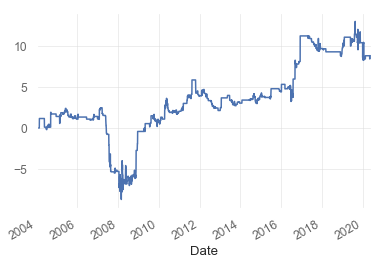

In [32]:
tabSignals['PL'].cumsum().plot()

In [16]:
tabSignals[tabSignals['Ticker']=='FXI']['PL'].mean()

0.08427672955974844

In [20]:
tabSignals[tabSignals['Ticker']=='IEF']['PL'].sum()

5.0600000000000005

In [19]:
tabSignals[tabSignals['Ticker']=='IWS']['PL'].sum()

0.8

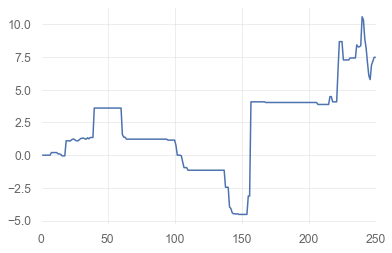

In [10]:
tabSignals = pd.read_csv(r'D:\rvm\ВК\OptionTesting\tabSignals31.csv', sep=';', header=0)
tabSignals['PL'].cumsum().plot()

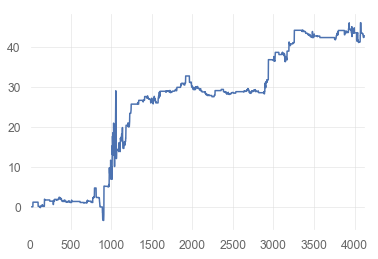

In [4]:
tabSignals = pd.read_csv(r'Delta025TP3.csv', sep=';', header=0)
tabSignals['PL'].cumsum().plot()

In [7]:
#
chinaIndex = 'FXI'
midCapUS = 'IWS'
bondTreasures = 'IEF'
tabSignals['Ticker'] = 'ticker'
tabSignals['Direction'] = 0.0
#
tabSignals['UnderlyingPrice'] = 0.0
#
priceEnter = 0
ulPriceEnter = 0
indEnter = 0
# 
for ij in range(0,len(tabSignals)-1):
    print ('{0}::{1}'.format(ij, tabSignals['Date1'].iloc[ij]))
    #
    if tabSignals['signal_hsi(china index)'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = chinaIndex
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_hsi(china index)'].iloc[ij]
    elif tabSignals['signal_mid cap_US_ind'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = midCapUS
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_mid cap_US_ind'].iloc[ij]
    elif tabSignals['signal_bond(Treasures)'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = bondTreasures
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_bond(Treasures)'].iloc[ij]
        
    # 
    ddf = getData(tabSignals['Ticker'].iloc[ij], tabSignals['Date1'].iloc[ij])
    if len(ddf) > 0:
        tabSignals['UnderlyingPrice'].iloc[ij] = ddf['UnderlyingPrice'].iloc[0]

0::2004-01-05 00:00:00
1::2004-01-06 00:00:00
2::2004-01-07 00:00:00
3::2004-01-08 00:00:00
4::2004-01-09 00:00:00
5::2004-01-12 00:00:00
6::2004-01-13 00:00:00
7::2004-01-14 00:00:00
8::2004-01-15 00:00:00
9::2004-01-16 00:00:00
10::2004-01-20 00:00:00
11::2004-01-21 00:00:00
12::2004-01-22 00:00:00
13::2004-01-23 00:00:00
14::2004-01-26 00:00:00
15::2004-01-27 00:00:00
16::2004-01-28 00:00:00
17::2004-01-29 00:00:00
18::2004-01-30 00:00:00
19::2004-02-02 00:00:00
20::2004-02-03 00:00:00
21::2004-02-04 00:00:00
22::2004-02-05 00:00:00
23::2004-02-06 00:00:00
24::2004-02-09 00:00:00
25::2004-02-10 00:00:00
26::2004-02-11 00:00:00
27::2004-02-12 00:00:00
28::2004-02-13 00:00:00
29::2004-02-17 00:00:00
30::2004-02-18 00:00:00
31::2004-02-19 00:00:00
32::2004-02-20 00:00:00
33::2004-02-23 00:00:00
34::2004-02-24 00:00:00
35::2004-02-25 00:00:00
36::2004-02-26 00:00:00
37::2004-02-27 00:00:00
38::2004-03-01 00:00:00
39::2004-03-02 00:00:00
40::2004-03-03 00:00:00
41::2004-03-04 00:00:00
42

667::2006-08-31 00:00:00
668::2006-09-01 00:00:00
669::2006-09-05 00:00:00
670::2006-09-06 00:00:00
671::2006-09-07 00:00:00
672::2006-09-08 00:00:00
673::2006-09-11 00:00:00
674::2006-09-12 00:00:00
675::2006-09-13 00:00:00
676::2006-09-14 00:00:00
677::2006-09-15 00:00:00
678::2006-09-18 00:00:00
679::2006-09-19 00:00:00
680::2006-09-20 00:00:00
681::2006-09-21 00:00:00
682::2006-09-22 00:00:00
683::2006-09-25 00:00:00
684::2006-09-26 00:00:00
685::2006-09-27 00:00:00
686::2006-09-28 00:00:00
687::2006-09-29 00:00:00
688::2006-10-02 00:00:00
689::2006-10-03 00:00:00
690::2006-10-04 00:00:00
691::2006-10-05 00:00:00
692::2006-10-06 00:00:00
693::2006-10-10 00:00:00
694::2006-10-11 00:00:00
695::2006-10-12 00:00:00
696::2006-10-13 00:00:00
697::2006-10-16 00:00:00
698::2006-10-17 00:00:00
699::2006-10-18 00:00:00
700::2006-10-19 00:00:00
701::2006-10-20 00:00:00
702::2006-10-23 00:00:00
703::2006-10-24 00:00:00
704::2006-10-25 00:00:00
705::2006-10-26 00:00:00
706::2006-10-27 00:00:00


998::2007-12-27 00:00:00
999::2007-12-28 00:00:00
1000::2007-12-31 00:00:00
1001::2008-01-02 00:00:00
1002::2008-01-03 00:00:00
1003::2008-01-04 00:00:00
1004::2008-01-07 00:00:00
1005::2008-01-08 00:00:00
1006::2008-01-09 00:00:00
1007::2008-01-10 00:00:00
1008::2008-01-11 00:00:00
1009::2008-01-14 00:00:00
1010::2008-01-15 00:00:00
1011::2008-01-16 00:00:00
1012::2008-01-17 00:00:00
1013::2008-01-18 00:00:00
1014::2008-01-22 00:00:00
1015::2008-01-23 00:00:00
1016::2008-01-24 00:00:00
1017::2008-01-25 00:00:00
1018::2008-01-28 00:00:00
1019::2008-01-29 00:00:00
1020::2008-01-30 00:00:00
1021::2008-01-31 00:00:00
1022::2008-02-01 00:00:00
1023::2008-02-04 00:00:00
1024::2008-02-05 00:00:00
1025::2008-02-06 00:00:00
1026::2008-02-07 00:00:00
1027::2008-02-08 00:00:00
1028::2008-02-11 00:00:00
1029::2008-02-12 00:00:00
1030::2008-02-13 00:00:00
1031::2008-02-14 00:00:00
1032::2008-02-15 00:00:00
1033::2008-02-19 00:00:00
1034::2008-02-20 00:00:00
1035::2008-02-21 00:00:00
1036::2008-02-

1318::2009-04-06 00:00:00
1319::2009-04-07 00:00:00
1320::2009-04-08 00:00:00
1321::2009-04-09 00:00:00
1322::2009-04-13 00:00:00
1323::2009-04-14 00:00:00
1324::2009-04-15 00:00:00
1325::2009-04-16 00:00:00
1326::2009-04-17 00:00:00
1327::2009-04-20 00:00:00
1328::2009-04-21 00:00:00
1329::2009-04-22 00:00:00
1330::2009-04-23 00:00:00
1331::2009-04-24 00:00:00
1332::2009-04-27 00:00:00
1333::2009-04-28 00:00:00
1334::2009-04-29 00:00:00
1335::2009-04-30 00:00:00
1336::2009-05-01 00:00:00
1337::2009-05-04 00:00:00
1338::2009-05-05 00:00:00
1339::2009-05-06 00:00:00
1340::2009-05-07 00:00:00
1341::2009-05-08 00:00:00
1342::2009-05-11 00:00:00
1343::2009-05-12 00:00:00
1344::2009-05-13 00:00:00
1345::2009-05-14 00:00:00
1346::2009-05-15 00:00:00
1347::2009-05-18 00:00:00
1348::2009-05-19 00:00:00
1349::2009-05-20 00:00:00
1350::2009-05-21 00:00:00
1351::2009-05-22 00:00:00
1352::2009-05-26 00:00:00
1353::2009-05-27 00:00:00
1354::2009-05-28 00:00:00
1355::2009-05-29 00:00:00
1356::2009-0

1637::2010-07-13 00:00:00
1638::2010-07-14 00:00:00
1639::2010-07-15 00:00:00
1640::2010-07-16 00:00:00
1641::2010-07-19 00:00:00
1642::2010-07-20 00:00:00
1643::2010-07-21 00:00:00
1644::2010-07-22 00:00:00
1645::2010-07-23 00:00:00
1646::2010-07-26 00:00:00
1647::2010-07-27 00:00:00
1648::2010-07-28 00:00:00
1649::2010-07-29 00:00:00
1650::2010-07-30 00:00:00
1651::2010-08-02 00:00:00
1652::2010-08-03 00:00:00
1653::2010-08-04 00:00:00
1654::2010-08-05 00:00:00
1655::2010-08-06 00:00:00
1656::2010-08-09 00:00:00
1657::2010-08-10 00:00:00
1658::2010-08-11 00:00:00
1659::2010-08-12 00:00:00
1660::2010-08-13 00:00:00
1661::2010-08-16 00:00:00
1662::2010-08-17 00:00:00
1663::2010-08-18 00:00:00
1664::2010-08-19 00:00:00
1665::2010-08-20 00:00:00
1666::2010-08-23 00:00:00
1667::2010-08-24 00:00:00
1668::2010-08-25 00:00:00
1669::2010-08-26 00:00:00
1670::2010-08-27 00:00:00
1671::2010-08-30 00:00:00
1672::2010-08-31 00:00:00
1673::2010-09-01 00:00:00
1674::2010-09-02 00:00:00
1675::2010-0

1959::2011-10-19 00:00:00
1960::2011-10-20 00:00:00
1961::2011-10-21 00:00:00
1962::2011-10-24 00:00:00
1963::2011-10-25 00:00:00
1964::2011-10-26 00:00:00
1965::2011-10-27 00:00:00
1966::2011-10-28 00:00:00
1967::2011-10-31 00:00:00
1968::2011-11-01 00:00:00
1969::2011-11-02 00:00:00
1970::2011-11-03 00:00:00
1971::2011-11-04 00:00:00
1972::2011-11-07 00:00:00
1973::2011-11-08 00:00:00
1974::2011-11-09 00:00:00
1975::2011-11-10 00:00:00
1976::2011-11-11 00:00:00
1977::2011-11-14 00:00:00
1978::2011-11-15 00:00:00
1979::2011-11-16 00:00:00
1980::2011-11-17 00:00:00
1981::2011-11-18 00:00:00
1982::2011-11-21 00:00:00
1983::2011-11-22 00:00:00
1984::2011-11-23 00:00:00
1985::2011-11-25 00:00:00
1986::2011-11-28 00:00:00
1987::2011-11-29 00:00:00
1988::2011-11-30 00:00:00
1989::2011-12-01 00:00:00
1990::2011-12-02 00:00:00
1991::2011-12-05 00:00:00
1992::2011-12-06 00:00:00
1993::2011-12-07 00:00:00
1994::2011-12-08 00:00:00
1995::2011-12-09 00:00:00
1996::2011-12-12 00:00:00
1997::2011-1

2279::2013-01-25 00:00:00
2280::2013-01-28 00:00:00
2281::2013-01-29 00:00:00
2282::2013-01-30 00:00:00
2283::2013-01-31 00:00:00
2284::2013-02-01 00:00:00
2285::2013-02-04 00:00:00
2286::2013-02-05 00:00:00
2287::2013-02-06 00:00:00
2288::2013-02-07 00:00:00
2289::2013-02-08 00:00:00
2290::2013-02-11 00:00:00
2291::2013-02-12 00:00:00
2292::2013-02-13 00:00:00
2293::2013-02-14 00:00:00
2294::2013-02-15 00:00:00
2295::2013-02-19 00:00:00
2296::2013-02-20 00:00:00
2297::2013-02-21 00:00:00
2298::2013-02-22 00:00:00
2299::2013-02-25 00:00:00
2300::2013-02-26 00:00:00
2301::2013-02-27 00:00:00
2302::2013-02-28 00:00:00
2303::2013-03-01 00:00:00
2304::2013-03-04 00:00:00
2305::2013-03-05 00:00:00
2306::2013-03-06 00:00:00
2307::2013-03-07 00:00:00
2308::2013-03-08 00:00:00
2309::2013-03-11 00:00:00
2310::2013-03-12 00:00:00
2311::2013-03-13 00:00:00
2312::2013-03-14 00:00:00
2313::2013-03-15 00:00:00
2314::2013-03-18 00:00:00
2315::2013-03-19 00:00:00
2316::2013-03-20 00:00:00
2317::2013-0

2597::2014-05-01 00:00:00
2598::2014-05-02 00:00:00
2599::2014-05-05 00:00:00
2600::2014-05-06 00:00:00
2601::2014-05-07 00:00:00
2602::2014-05-08 00:00:00
2603::2014-05-09 00:00:00
2604::2014-05-12 00:00:00
2605::2014-05-13 00:00:00
2606::2014-05-14 00:00:00
2607::2014-05-15 00:00:00
2608::2014-05-16 00:00:00
2609::2014-05-19 00:00:00
2610::2014-05-20 00:00:00
2611::2014-05-21 00:00:00
2612::2014-05-22 00:00:00
2613::2014-05-23 00:00:00
2614::2014-05-27 00:00:00
2615::2014-05-28 00:00:00
2616::2014-05-29 00:00:00
2617::2014-05-30 00:00:00
2618::2014-06-02 00:00:00
2619::2014-06-03 00:00:00
2620::2014-06-04 00:00:00
2621::2014-06-05 00:00:00
2622::2014-06-06 00:00:00
2623::2014-06-09 00:00:00
2624::2014-06-10 00:00:00
2625::2014-06-11 00:00:00
2626::2014-06-12 00:00:00
2627::2014-06-13 00:00:00
2628::2014-06-16 00:00:00
2629::2014-06-17 00:00:00
2630::2014-06-18 00:00:00
2631::2014-06-19 00:00:00
2632::2014-06-20 00:00:00
2633::2014-06-23 00:00:00
2634::2014-06-24 00:00:00
2635::2014-0

2917::2015-08-07 00:00:00
2918::2015-08-10 00:00:00
2919::2015-08-11 00:00:00
2920::2015-08-12 00:00:00
2921::2015-08-13 00:00:00
2922::2015-08-14 00:00:00
2923::2015-08-17 00:00:00
2924::2015-08-18 00:00:00
2925::2015-08-19 00:00:00
2926::2015-08-20 00:00:00
2927::2015-08-21 00:00:00
2928::2015-08-24 00:00:00
2929::2015-08-25 00:00:00
2930::2015-08-26 00:00:00
2931::2015-08-27 00:00:00
2932::2015-08-28 00:00:00
2933::2015-08-31 00:00:00
2934::2015-09-01 00:00:00
2935::2015-09-02 00:00:00
2936::2015-09-03 00:00:00
2937::2015-09-04 00:00:00
2938::2015-09-08 00:00:00
2939::2015-09-09 00:00:00
2940::2015-09-10 00:00:00
2941::2015-09-11 00:00:00
2942::2015-09-14 00:00:00
2943::2015-09-15 00:00:00
2944::2015-09-16 00:00:00
2945::2015-09-17 00:00:00
2946::2015-09-18 00:00:00
2947::2015-09-21 00:00:00
2948::2015-09-22 00:00:00
2949::2015-09-23 00:00:00
2950::2015-09-24 00:00:00
2951::2015-09-25 00:00:00
2952::2015-09-28 00:00:00
2953::2015-09-29 00:00:00
2954::2015-09-30 00:00:00
2955::2015-1

3236::2016-11-10 00:00:00
3237::2016-11-11 00:00:00
3238::2016-11-14 00:00:00
3239::2016-11-15 00:00:00
3240::2016-11-16 00:00:00
3241::2016-11-17 00:00:00
3242::2016-11-18 00:00:00
3243::2016-11-21 00:00:00
3244::2016-11-22 00:00:00
3245::2016-11-23 00:00:00
3246::2016-11-25 00:00:00
3247::2016-11-28 00:00:00
3248::2016-11-29 00:00:00
3249::2016-11-30 00:00:00
3250::2016-12-01 00:00:00
3251::2016-12-02 00:00:00
3252::2016-12-05 00:00:00
3253::2016-12-06 00:00:00
3254::2016-12-07 00:00:00
3255::2016-12-08 00:00:00
3256::2016-12-09 00:00:00
3257::2016-12-12 00:00:00
3258::2016-12-13 00:00:00
3259::2016-12-14 00:00:00
3260::2016-12-15 00:00:00
3261::2016-12-16 00:00:00
3262::2016-12-19 00:00:00
3263::2016-12-20 00:00:00
3264::2016-12-21 00:00:00
3265::2016-12-22 00:00:00
3266::2016-12-23 00:00:00
3267::2016-12-27 00:00:00
3268::2016-12-28 00:00:00
3269::2016-12-29 00:00:00
3270::2016-12-30 00:00:00
3271::2017-01-03 00:00:00
3272::2017-01-04 00:00:00
3273::2017-01-05 00:00:00
3274::2017-0

3560::2018-02-27 00:00:00
3561::2018-02-28 00:00:00
3562::2018-03-01 00:00:00
3563::2018-03-02 00:00:00
3564::2018-03-05 00:00:00
3565::2018-03-06 00:00:00
3566::2018-03-07 00:00:00
3567::2018-03-08 00:00:00
3568::2018-03-09 00:00:00
3569::2018-03-12 00:00:00
3570::2018-03-13 00:00:00
3571::2018-03-14 00:00:00
3572::2018-03-15 00:00:00
3573::2018-03-16 00:00:00
3574::2018-03-19 00:00:00
3575::2018-03-20 00:00:00
3576::2018-03-21 00:00:00
3577::2018-03-22 00:00:00
3578::2018-03-23 00:00:00
3579::2018-03-26 00:00:00
3580::2018-03-27 00:00:00
3581::2018-03-28 00:00:00
3582::2018-03-29 00:00:00
3583::2018-04-02 00:00:00
3584::2018-04-03 00:00:00
3585::2018-04-04 00:00:00
3586::2018-04-05 00:00:00
3587::2018-04-06 00:00:00
3588::2018-04-09 00:00:00
3589::2018-04-10 00:00:00
3590::2018-04-11 00:00:00
3591::2018-04-12 00:00:00
3592::2018-04-13 00:00:00
3593::2018-04-16 00:00:00
3594::2018-04-17 00:00:00
3595::2018-04-18 00:00:00
3596::2018-04-19 00:00:00
3597::2018-04-20 00:00:00
3598::2018-0

3878::2019-06-04 00:00:00
3879::2019-06-05 00:00:00
3880::2019-06-06 00:00:00
3881::2019-06-07 00:00:00
3882::2019-06-10 00:00:00
3883::2019-06-11 00:00:00
3884::2019-06-12 00:00:00
3885::2019-06-13 00:00:00
3886::2019-06-14 00:00:00
3887::2019-06-17 00:00:00
3888::2019-06-18 00:00:00
3889::2019-06-19 00:00:00
3890::2019-06-20 00:00:00
3891::2019-06-21 00:00:00
3892::2019-06-24 00:00:00
3893::2019-06-25 00:00:00
3894::2019-06-26 00:00:00
3895::2019-06-27 00:00:00
3896::2019-06-28 00:00:00
3897::2019-07-01 00:00:00
3898::2019-07-02 00:00:00
3899::2019-07-03 00:00:00
3900::2019-07-05 00:00:00
3901::2019-07-08 00:00:00
3902::2019-07-09 00:00:00
3903::2019-07-10 00:00:00
3904::2019-07-11 00:00:00
3905::2019-07-12 00:00:00
3906::2019-07-15 00:00:00
3907::2019-07-16 00:00:00
3908::2019-07-17 00:00:00
3909::2019-07-18 00:00:00
3910::2019-07-19 00:00:00
3911::2019-07-22 00:00:00
3912::2019-07-23 00:00:00
3913::2019-07-24 00:00:00
3914::2019-07-25 00:00:00
3915::2019-07-26 00:00:00
3916::2019-0

In [9]:
tabSignals['PL'] = 0.0
for i in range(1, len(tabSignals)-1):
    if tabSignals['Ticker'].iloc[i-1] == tabSignals['Ticker'].iloc[i]:
        tabSignals['PL'].iloc[i] = tabSignals['Direction'].iloc[i] * (tabSignals['UnderlyingPrice'].iloc[i] - tabSignals['UnderlyingPrice'].iloc[i-1])

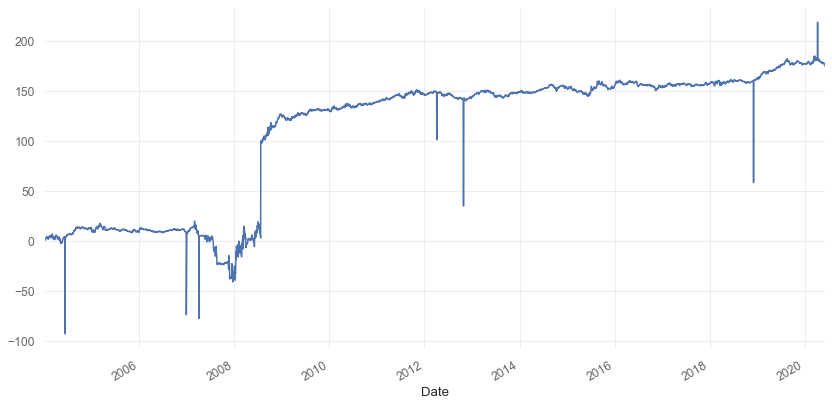

In [14]:
tabSignals['PL'].cumsum().plot(figsize=(14,7))

In [115]:
methodOption = 'ATM111'
neededDelta = 0.1
takeProfit = 3   
#
takeIsComing = ''
#
chinaIndex = 'FXI'
midCapUS = 'IWS'
bondTreasures = 'IEF'
tabSignals['Ticker'] = 'ticker'
tabSignals['Direction'] = 0.0
#
tabSignals['OptionName'] = ''
tabSignals['Price'] = 0.0
tabSignals['UnderlyingPrice'] = 0.0
tabSignals['Delta'] = 0.0
tabSignals['Expiration'] = ''
tabSignals['Details'] = ''
tabSignals['Strike'] = 0.0
tabSignals['Volume'] = 0.0
tabSignals['OpenInterest'] = 0.0
tabSignals['T1OpenInterest'] = 0.0
tabSignals['PL'] = 0.0
#
priceEnter = 0
ulPriceEnter = 0
indEnter = 0
# 
for ij in range(0,len(tabSignals)-1):
    print ('{0}::{1}'.format(ij, tabSignals['Date1'].iloc[ij]))
    #
    if tabSignals['signal_hsi(china index)'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = chinaIndex
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_hsi(china index)'].iloc[ij]
    elif tabSignals['signal_mid cap_US_ind'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = midCapUS
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_mid cap_US_ind'].iloc[ij]
    elif tabSignals['signal_bond(Treasures)'].iloc[ij] != 0:
        tabSignals['Ticker'].iloc[ij] = bondTreasures
        tabSignals['Direction'].iloc[ij] = tabSignals['signal_bond(Treasures)'].iloc[ij]
        
    # 
    ddf = getData(tabSignals['Ticker'].iloc[ij], tabSignals['Date1'].iloc[ij])
    if len(ddf) > 0:
        ddf1 = pd.DataFrame()
        if ij != 0:
            if tabSignals['OptionName'].iloc[ij-1] != '':
                ddf1 = ddf[ddf['OptionSymbol'] == tabSignals['OptionName'].iloc[ij-1]]
    
        if len(ddf1) == 0 or tabSignals['Details'].iloc[ij-1].find('Exit') >= 0:
            if methodOption == 'ATM':
                ddf1 = getATM(ddf, tabSignals['Direction'].iloc[ij])
            else:
                ddf1 = getDelta(ddf, tabSignals['Direction'].iloc[ij], neededDelta, tabSignals['Date1'].iloc[ij])
                
            #ddf1 = ddf[ddf['Type'] == getOptionType(tabSignals['Direction'].iloc[ij])]
            #dd = 0.1
            #delta = getNeededDelta(dd, ddf1['Delta'].unique())
            #ddf1 = ddf[ddf['Delta']==delta]
            if takeIsComing != '':
                if takeIsComing == tabSignals['Ticker'].iloc[ij]:
                    continue
            #
            if len(ddf1) == 0:
                continue
            
            takeIsComing = ''
            tabSignals['Details'].iloc[ij] = 'Enter'
            tabSignals['Price'].iloc[ij] = getPrice(ddf1['Last'].iloc[0], ddf1['Ask'].iloc[0], ddf1['Bid'].iloc[0])
            priceEnter = tabSignals['Price'].iloc[ij]
            ulPriceEnter = ddf1['UnderlyingPrice'].iloc[0]
            indEnter = ij
            
            if ij != 0:
                if tabSignals['Ticker'].iloc[ij] != tabSignals['Ticker'].iloc[ij-1]:
                    if tabSignals['Details'].iloc[ij-1] == 'Enter':
                        dr = getData(tabSignals['Ticker'].iloc[ij-1], tabSignals['Date1'].iloc[ij])
                        dm = getOptionName(dr, tabSignals['OptionName'].iloc[ij-1])
                        if len(dm) > 0:
                            priceP = getPrice(dm['Last'].iloc[0], dm['Ask'].iloc[0], dm['Bid'].iloc[0])
                            tabSignals['Details'].iloc[ij-1] = 'Enter;Exit_Signal;Price={0}'.format(priceP)
                            tabSignals['PL'].iloc[ij-1] = priceP - tabSignals['Price'].iloc[ij-1]  
                    else:
                        if tabSignals['Details'].iloc[ij-1] != '':
                            tabSignals['Details'].iloc[ij-1] = 'Exit_Signal'
        else:
            tabSignals['Details'].iloc[ij] = 'in'
            tabSignals['Price'].iloc[ij] = getPrice(ddf1['Last'].iloc[0], ddf1['Ask'].iloc[0], ddf1['Bid'].iloc[0])
        
        tabSignals['OptionName'].iloc[ij] = ddf1['OptionSymbol'].iloc[0]
        tabSignals['UnderlyingPrice'].iloc[ij] =  ddf1['UnderlyingPrice'].iloc[0]
        tabSignals['Delta'].iloc[ij] = ddf1['Delta'].iloc[0]
        tabSignals['Expiration'].iloc[ij] = ddf1['Expiration'].iloc[0] 
        tabSignals['Strike'].iloc[ij] = ddf1['Strike'].iloc[0]
        tabSignals['Volume'].iloc[ij] = ddf1['Volume'].iloc[0]
        tabSignals['OpenInterest'].iloc[ij] = ddf1['OpenInterest'].iloc[0]
        tabSignals['T1OpenInterest'].iloc[ij] = ddf1['T1OpenInterest'].iloc[0]
        
        if ij != 0:
            if tabSignals['OptionName'].iloc[ij-1] == tabSignals['OptionName'].iloc[ij]:
                tabSignals['PL'].iloc[ij] = tabSignals['Price'].iloc[ij] - tabSignals['Price'].iloc[ij-1]
        
        if tabSignals['Details'].iloc[ij] == 'in':
            if tabSignals['Price'].iloc[ij] >= takeProfit * priceEnter:
                tabSignals['Details'].iloc[ij] = 'Exit_TakeP'
                takeIsComing = tabSignals['Ticker'].iloc[ij]
            if ij + 1 < len(tabSignals):
                if tabSignals['Date1'].iloc[ij] <= tabSignals['Expiration'].iloc[ij] and tabSignals['Expiration'].iloc[ij] <= tabSignals['Date1'].iloc[ij+1]:
                    #takeIsComing = tabSignals['Ticker'].iloc[ij] # если не нужно заходить после экспирации
                    tabSignals['Details'].iloc[ij] = 'Exit_Expir'
                    if tabSignals['Direction'].iloc[ij] == 1: 
                        tabSignals['PL'].iloc[ij] = max(tabSignals['UnderlyingPrice'].iloc[ij]-tabSignals['Strike'].iloc[ij],0)-priceEnter
                    elif tabSignals['Direction'].iloc[ij] == -1:
                        tabSignals['PL'].iloc[ij] = max(tabSignals['Strike'].iloc[ij]-tabSignals['UnderlyingPrice'].iloc[ij],0)-priceEnter
                    for el in range(indEnter, ij):
                        tabSignals['PL'].iloc[el] = 0.0
                        
tabSignals.to_csv(r'tabSignals1.csv', sep=';')

0::2004-01-05 00:00:00


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1::2004-01-06 00:00:00
2::2004-01-07 00:00:00
3::2004-01-08 00:00:00
4::2004-01-09 00:00:00
5::2004-01-12 00:00:00
6::2004-01-13 00:00:00
7::2004-01-14 00:00:00
8::2004-01-15 00:00:00
9::2004-01-16 00:00:00
10::2004-01-20 00:00:00
11::2004-01-21 00:00:00
12::2004-01-22 00:00:00
13::2004-01-23 00:00:00
14::2004-01-26 00:00:00
15::2004-01-27 00:00:00
16::2004-01-28 00:00:00
17::2004-01-29 00:00:00
18::2004-01-30 00:00:00
19::2004-02-02 00:00:00
20::2004-02-03 00:00:00
21::2004-02-04 00:00:00
22::2004-02-05 00:00:00
23::2004-02-06 00:00:00
24::2004-02-09 00:00:00
25::2004-02-10 00:00:00
26::2004-02-11 00:00:00
27::2004-02-12 00:00:00
28::2004-02-13 00:00:00
29::2004-02-17 00:00:00
30::2004-02-18 00:00:00
31::2004-02-19 00:00:00
32::2004-02-20 00:00:00
33::2004-02-23 00:00:00
34::2004-02-24 00:00:00
35::2004-02-25 00:00:00
36::2004-02-26 00:00:00
37::2004-02-27 00:00:00
38::2004-03-01 00:00:00
39::2004-03-02 00:00:00
40::2004-03-03 00:00:00
41::2004-03-04 00:00:00
42::2004-03-05 00:00:00
4

334::2005-05-04 00:00:00
335::2005-05-05 00:00:00
336::2005-05-06 00:00:00
337::2005-05-09 00:00:00
338::2005-05-10 00:00:00
339::2005-05-11 00:00:00
340::2005-05-12 00:00:00
341::2005-05-13 00:00:00
342::2005-05-16 00:00:00
343::2005-05-17 00:00:00
344::2005-05-18 00:00:00
345::2005-05-19 00:00:00
346::2005-05-20 00:00:00
347::2005-05-23 00:00:00
348::2005-05-24 00:00:00
349::2005-05-25 00:00:00
350::2005-05-26 00:00:00
351::2005-05-27 00:00:00
352::2005-05-31 00:00:00
353::2005-06-01 00:00:00
354::2005-06-02 00:00:00
355::2005-06-03 00:00:00
356::2005-06-06 00:00:00
357::2005-06-07 00:00:00
358::2005-06-08 00:00:00
359::2005-06-09 00:00:00
360::2005-06-10 00:00:00
361::2005-06-13 00:00:00
362::2005-06-14 00:00:00
363::2005-06-15 00:00:00
364::2005-06-16 00:00:00
365::2005-06-17 00:00:00
366::2005-06-20 00:00:00
367::2005-06-21 00:00:00
368::2005-06-22 00:00:00
369::2005-06-23 00:00:00
370::2005-06-24 00:00:00
371::2005-06-27 00:00:00
372::2005-06-28 00:00:00
373::2005-06-29 00:00:00


662::2006-08-24 00:00:00
663::2006-08-25 00:00:00
664::2006-08-28 00:00:00
665::2006-08-29 00:00:00
666::2006-08-30 00:00:00
667::2006-08-31 00:00:00
668::2006-09-01 00:00:00
669::2006-09-05 00:00:00
670::2006-09-06 00:00:00
671::2006-09-07 00:00:00
672::2006-09-08 00:00:00
673::2006-09-11 00:00:00
674::2006-09-12 00:00:00
675::2006-09-13 00:00:00
676::2006-09-14 00:00:00
677::2006-09-15 00:00:00
678::2006-09-18 00:00:00
679::2006-09-19 00:00:00
680::2006-09-20 00:00:00
681::2006-09-21 00:00:00
682::2006-09-22 00:00:00
683::2006-09-25 00:00:00
684::2006-09-26 00:00:00
685::2006-09-27 00:00:00
686::2006-09-28 00:00:00
687::2006-09-29 00:00:00
688::2006-10-02 00:00:00
689::2006-10-03 00:00:00
690::2006-10-04 00:00:00
691::2006-10-05 00:00:00
692::2006-10-06 00:00:00
693::2006-10-10 00:00:00
694::2006-10-11 00:00:00
695::2006-10-12 00:00:00
696::2006-10-13 00:00:00
697::2006-10-16 00:00:00
698::2006-10-17 00:00:00
699::2006-10-18 00:00:00
700::2006-10-19 00:00:00
701::2006-10-20 00:00:00


990::2007-12-14 00:00:00
991::2007-12-17 00:00:00
992::2007-12-18 00:00:00
993::2007-12-19 00:00:00
994::2007-12-20 00:00:00
995::2007-12-21 00:00:00
996::2007-12-24 00:00:00
997::2007-12-26 00:00:00
998::2007-12-27 00:00:00
999::2007-12-28 00:00:00
1000::2007-12-31 00:00:00
1001::2008-01-02 00:00:00
1002::2008-01-03 00:00:00
1003::2008-01-04 00:00:00
1004::2008-01-07 00:00:00
1005::2008-01-08 00:00:00
1006::2008-01-09 00:00:00
1007::2008-01-10 00:00:00
1008::2008-01-11 00:00:00
1009::2008-01-14 00:00:00
1010::2008-01-15 00:00:00
1011::2008-01-16 00:00:00
1012::2008-01-17 00:00:00
1013::2008-01-18 00:00:00
1014::2008-01-22 00:00:00
1015::2008-01-23 00:00:00
1016::2008-01-24 00:00:00
1017::2008-01-25 00:00:00
1018::2008-01-28 00:00:00
1019::2008-01-29 00:00:00
1020::2008-01-30 00:00:00
1021::2008-01-31 00:00:00
1022::2008-02-01 00:00:00
1023::2008-02-04 00:00:00
1024::2008-02-05 00:00:00
1025::2008-02-06 00:00:00
1026::2008-02-07 00:00:00
1027::2008-02-08 00:00:00
1028::2008-02-11 00:00

1306::2009-03-19 00:00:00
1307::2009-03-20 00:00:00
1308::2009-03-23 00:00:00
1309::2009-03-24 00:00:00
1310::2009-03-25 00:00:00
1311::2009-03-26 00:00:00
1312::2009-03-27 00:00:00
1313::2009-03-30 00:00:00
1314::2009-03-31 00:00:00
1315::2009-04-01 00:00:00
1316::2009-04-02 00:00:00
1317::2009-04-03 00:00:00
1318::2009-04-06 00:00:00
1319::2009-04-07 00:00:00
1320::2009-04-08 00:00:00
1321::2009-04-09 00:00:00
1322::2009-04-13 00:00:00
1323::2009-04-14 00:00:00
1324::2009-04-15 00:00:00
1325::2009-04-16 00:00:00
1326::2009-04-17 00:00:00
1327::2009-04-20 00:00:00
1328::2009-04-21 00:00:00
1329::2009-04-22 00:00:00
1330::2009-04-23 00:00:00
1331::2009-04-24 00:00:00
1332::2009-04-27 00:00:00
1333::2009-04-28 00:00:00
1334::2009-04-29 00:00:00
1335::2009-04-30 00:00:00
1336::2009-05-01 00:00:00
1337::2009-05-04 00:00:00
1338::2009-05-05 00:00:00
1339::2009-05-06 00:00:00
1340::2009-05-07 00:00:00
1341::2009-05-08 00:00:00
1342::2009-05-11 00:00:00
1343::2009-05-12 00:00:00
1344::2009-0

1622::2010-06-21 00:00:00
1623::2010-06-22 00:00:00
1624::2010-06-23 00:00:00
1625::2010-06-24 00:00:00
1626::2010-06-25 00:00:00
1627::2010-06-28 00:00:00
1628::2010-06-29 00:00:00
1629::2010-06-30 00:00:00
1630::2010-07-01 00:00:00
1631::2010-07-02 00:00:00
1632::2010-07-06 00:00:00
1633::2010-07-07 00:00:00
1634::2010-07-08 00:00:00
1635::2010-07-09 00:00:00
1636::2010-07-12 00:00:00
1637::2010-07-13 00:00:00
1638::2010-07-14 00:00:00
1639::2010-07-15 00:00:00
1640::2010-07-16 00:00:00
1641::2010-07-19 00:00:00
1642::2010-07-20 00:00:00
1643::2010-07-21 00:00:00
1644::2010-07-22 00:00:00
1645::2010-07-23 00:00:00
1646::2010-07-26 00:00:00
1647::2010-07-27 00:00:00
1648::2010-07-28 00:00:00
1649::2010-07-29 00:00:00
1650::2010-07-30 00:00:00
1651::2010-08-02 00:00:00
1652::2010-08-03 00:00:00
1653::2010-08-04 00:00:00
1654::2010-08-05 00:00:00
1655::2010-08-06 00:00:00
1656::2010-08-09 00:00:00
1657::2010-08-10 00:00:00
1658::2010-08-11 00:00:00
1659::2010-08-12 00:00:00
1660::2010-0

1938::2011-09-20 00:00:00
1939::2011-09-21 00:00:00
1940::2011-09-22 00:00:00
1941::2011-09-23 00:00:00
1942::2011-09-26 00:00:00
1943::2011-09-27 00:00:00
1944::2011-09-28 00:00:00
1945::2011-09-29 00:00:00
1946::2011-09-30 00:00:00
1947::2011-10-03 00:00:00
1948::2011-10-04 00:00:00
1949::2011-10-05 00:00:00
1950::2011-10-06 00:00:00
1951::2011-10-07 00:00:00
1952::2011-10-10 00:00:00
1953::2011-10-11 00:00:00
1954::2011-10-12 00:00:00
1955::2011-10-13 00:00:00
1956::2011-10-14 00:00:00
1957::2011-10-17 00:00:00
1958::2011-10-18 00:00:00
1959::2011-10-19 00:00:00
1960::2011-10-20 00:00:00
1961::2011-10-21 00:00:00
1962::2011-10-24 00:00:00
1963::2011-10-25 00:00:00
1964::2011-10-26 00:00:00
1965::2011-10-27 00:00:00
1966::2011-10-28 00:00:00
1967::2011-10-31 00:00:00
1968::2011-11-01 00:00:00
1969::2011-11-02 00:00:00
1970::2011-11-03 00:00:00
1971::2011-11-04 00:00:00
1972::2011-11-07 00:00:00
1973::2011-11-08 00:00:00
1974::2011-11-09 00:00:00
1975::2011-11-10 00:00:00
1976::2011-1

2254::2012-12-18 00:00:00
2255::2012-12-19 00:00:00
2256::2012-12-20 00:00:00
2257::2012-12-21 00:00:00
2258::2012-12-24 00:00:00
2259::2012-12-26 00:00:00
2260::2012-12-27 00:00:00
2261::2012-12-28 00:00:00
2262::2012-12-31 00:00:00
2263::2013-01-02 00:00:00
2264::2013-01-03 00:00:00
2265::2013-01-04 00:00:00
2266::2013-01-07 00:00:00
2267::2013-01-08 00:00:00
2268::2013-01-09 00:00:00
2269::2013-01-10 00:00:00
2270::2013-01-11 00:00:00
2271::2013-01-14 00:00:00
2272::2013-01-15 00:00:00
2273::2013-01-16 00:00:00
2274::2013-01-17 00:00:00
2275::2013-01-18 00:00:00
2276::2013-01-22 00:00:00
2277::2013-01-23 00:00:00
2278::2013-01-24 00:00:00
2279::2013-01-25 00:00:00
2280::2013-01-28 00:00:00
2281::2013-01-29 00:00:00
2282::2013-01-30 00:00:00
2283::2013-01-31 00:00:00
2284::2013-02-01 00:00:00
2285::2013-02-04 00:00:00
2286::2013-02-05 00:00:00
2287::2013-02-06 00:00:00
2288::2013-02-07 00:00:00
2289::2013-02-08 00:00:00
2290::2013-02-11 00:00:00
2291::2013-02-12 00:00:00
2292::2013-0

2570::2014-03-24 00:00:00
2571::2014-03-25 00:00:00
2572::2014-03-26 00:00:00
2573::2014-03-27 00:00:00
2574::2014-03-28 00:00:00
2575::2014-03-31 00:00:00
2576::2014-04-01 00:00:00
2577::2014-04-02 00:00:00
2578::2014-04-03 00:00:00
2579::2014-04-04 00:00:00
2580::2014-04-07 00:00:00
2581::2014-04-08 00:00:00
2582::2014-04-09 00:00:00
2583::2014-04-10 00:00:00
2584::2014-04-11 00:00:00
2585::2014-04-14 00:00:00
2586::2014-04-15 00:00:00
2587::2014-04-16 00:00:00
2588::2014-04-17 00:00:00
2589::2014-04-21 00:00:00
2590::2014-04-22 00:00:00
2591::2014-04-23 00:00:00
2592::2014-04-24 00:00:00
2593::2014-04-25 00:00:00
2594::2014-04-28 00:00:00
2595::2014-04-29 00:00:00
2596::2014-04-30 00:00:00
2597::2014-05-01 00:00:00
2598::2014-05-02 00:00:00
2599::2014-05-05 00:00:00
2600::2014-05-06 00:00:00
2601::2014-05-07 00:00:00
2602::2014-05-08 00:00:00
2603::2014-05-09 00:00:00
2604::2014-05-12 00:00:00
2605::2014-05-13 00:00:00
2606::2014-05-14 00:00:00
2607::2014-05-15 00:00:00
2608::2014-0

KeyboardInterrupt: 

In [117]:
tabSignals.to_csv(r'tabSignals2.csv', sep=';')

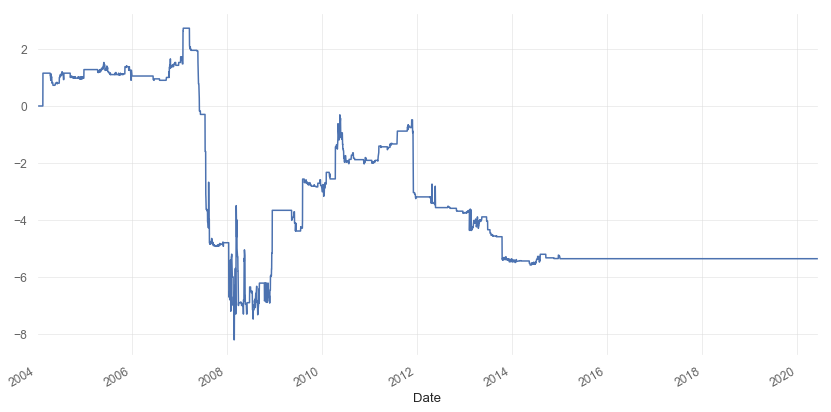

In [116]:
tabSignals['PL'].cumsum().plot(figsize=(14,7))

In [78]:
tabSignals[tabSignals['Ticker']=='FXI']['PL'].mean()

nan

In [80]:
tabSignals[tabSignals['Ticker']=='IWS']['PL'].sum()

-0.25999999999999673

In [81]:
tabSignals[tabSignals['Ticker']=='IEF']['PL'].mean()

-0.0021052631578947364